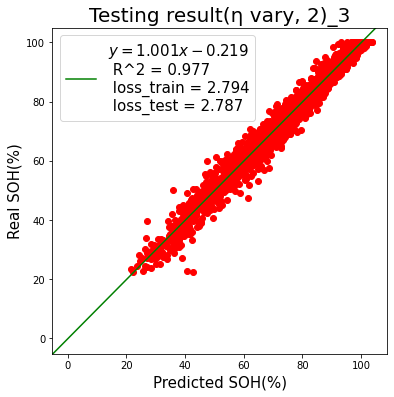

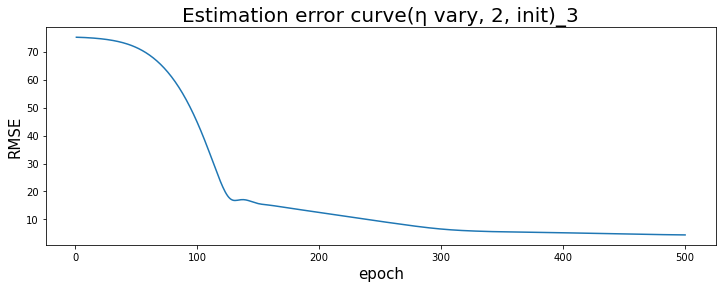

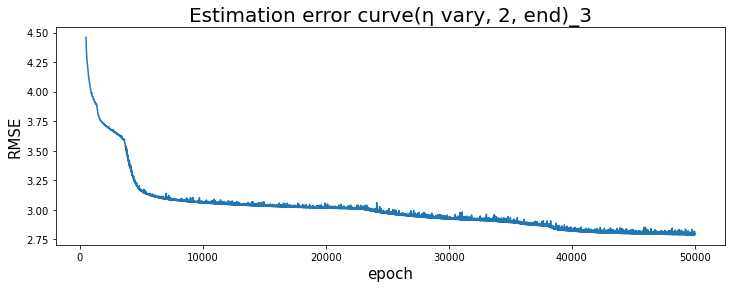

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x000001E9A5021C88>, lambda_l2 = 0.0002
Result_train =  [2.964677, 2.752747, 2.803033, 2.793924]
2.829
Result_test =  [3.075856, 2.972382, 2.802218, 2.786885]
2.909
total_corr(^2) =  [0.972, 0.973, 0.977, 0.977]
0.975


NameError: name 'factor' is not defined

In [51]:
'''ML_noerror.csv, varying learning rate:更動optimizer出現位置'''
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

D = 5  # dimensions
C = 1  # num_classes
H1 = 50  # num_hidden_units_1
H2 = 5  # num_hidden_units_2

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data_r[:,1:6])     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data_r[:,1:6])
data_SOH = data_r[:,0:1]
data = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
# learning_rate = 3e-3
lambda_l2 = 2e-4
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];

for i in range(4):
    train_set = [];
    test_set = [];
    eveloss = [];
    lrlist = []
    models = list()
    y_pretrain = list()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for j in range(len(data)):
        if j%10 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    X = torch.from_numpy(data[train_set,1:6].astype(np.float64))
    y = torch.from_numpy(data[train_set,0:1].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,1:6].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,0:1].astype(np.float64))
    for mod in range(n_networks):
      # nn package to create our linear model     # https://stackoverflow.com/questions/46141690/how-do-i-write-a-pytorch-sequential-model
      # each Linear module has a weight and bias     # https://discuss.pytorch.org/t/mlp-with-one-hidden-layer-dimensions-modules/48841
        model = nn.Sequential(
            nn.Linear(D, H1),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H1, H2),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H2, C)
        )
        model.to(device)
      # Append models
        models.append(model)
      # we use the optim package to apply ADAM
      # for our parameter updates
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=lambda_l2)     # built-in L2, momentum=0.9
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
        # learning_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True, threshold = 0.004, threshold_mode = 'rel', cooldown=500, min_lr = 0.003, eps = 1e-07)     # , factor=0.5, patience=20, verbose=False, threshold = 0.0001, threshold_mode = 'rel', cooldown=0, min_lr = 0, eps = 1e-08 
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 24000, 0.71, last_epoch=-1)
      # e = 1.  # plotting purpose.
      ## Training
        for t in range(1,50001,1):
          # Feed forward to get the logits
            y_pred = model(X.float())
          # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
            loss = torch.sqrt(criterion(y_pred.float(), y.float()))
            eveloss.append(np.round(loss.item(),6))
          # we use the optim package to apply ADAM
          # for our parameter updates
            print(f"[Round]: {i+1}, [MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")     # , [lr]: {learning_rate}
            print(optimizer)
            display.clear_output(wait=True)
          # zero the gradients before running
          # the backward pass.
            optimizer.zero_grad()
          # Backward pass to compute the gradient of loss w.r.t our learnable params. 
            loss.backward()
          # Update params
            optimizer.step()
            learning_rate.step(loss)
            if t == 50000:
                totalerr_train.append(np.round(loss.item(),6))  
              ## Testing
                y_test_pred = model(X_test.float())
              # Compute the loss and accuracy
                loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
                y_test_array = []; y_test_pred_array = [];
                for ii in range(len(y_test)):
                    y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))
                    y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
                R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1],造成dead kernel
                R_sq = np.round(R*R,3)
                totalerr_test.append(np.round(loss_test.item(),6))
                total_corr.append(np.round(R_sq,3))
                ## 畫圖    ### 試驗浮動學習率時改過'title'名稱,正式訓練時要改回來 ###
                plt.figure(figsize=(6,6))
                plt.plot(y_test_pred_array, y_test_array, 'ro');     #
                m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
                plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n R^2 = {R_sq}\n loss_train = {loss.item():.3f}\n loss_test = {loss_test:.3f}') # 
                plt.xlabel("Predicted SOH(%)", fontsize=15)
                plt.ylabel("Real SOH(%)", fontsize=15)
                plt.title("Testing result(η vary, 2)" + "_" + f"{i}", fontsize=20);
                plt.legend(fontsize=15);
                plt.savefig("Testing result" + "_Round " + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(1,501,1),eveloss[1:501]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η vary, 2, init)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η vary, 2, init)" + "_" + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(501,50000,1),eveloss[501:]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η vary, 2, end)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η vary, 2, end)" + "_" + f"{i}" + ".jpg"); plt.show();''' #save as jpg'''

print("hyperparameters = ", 'Epoch = ' + f"{t}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))
print(" factor="+f"{factor}" + ", patience="+f"{patience}" + ", threshold="+f"{threshold}" + ", cooldown=" + f"{cooldown}" + ", min_lr=" + f"{min_lr}" + ", eps=" + f"{eps}")


In [ ]:
hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x000001E9A5021C88>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=lambda_l2)     # built-in L2, momentum=0.9
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 24000, 0.71, last_epoch=-1)
Result_train =  [2.964677, 2.752747, 2.803033, 2.793924]
2.829
Result_test =  [3.075856, 2.972382, 2.802218, 2.786885]
2.909
total_corr(^2) =  [0.972, 0.973, 0.977, 0.977]
0.975

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x000001E9A0C11F48>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=lambda_l2)     # built-in L2, momentum=0.9
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 30000, 10, last_epoch=-1)
Result_train =  [2.888839, 2.765833, 2.747552, 2.840352]
2.811
Result_test =  [2.911224, 2.893063, 2.731976, 2.881141]
2.854
total_corr(^2) =  [0.975, 0.975, 0.978, 0.975]
0.976

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A43BAC08>, lambda_l2 = 0.0002
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
        (factor=0.5, patience=100, threshold = 0.004, cooldown=500, min_lr = 0.003, eps = 1e-07)     # , factor=0.5, patience=20, verbose=False, threshold = 0.0001, threshold_mode = 'rel', cooldown=0, min_lr = 0, eps = 1e-08 
Result_train =  [3.510257, 18.234457, 3.459266, 3.267336, 3.418001]
6.378
Result_test =  [3.819941, 18.16778, 3.475781, 3.283602, 3.420628]
6.434
total_corr(^2) =  [0.957, nan, 0.965, 0.97, 0.965]
nan

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A42DE5C8>, lambda_l2 = 0.0002
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.8)
        (factor=0.5, patience=100, threshold = 0.004, cooldown=1000, min_lr = 0.0015, eps = 1e-07)     # , factor=0.5, patience=20, verbose=False, threshold = 0.0001, threshold_mode = 'rel', cooldown=0, min_lr = 0, eps = 1e-08 
Result_train =  [2.84908, 2.952478, 2.955413, 2.840543, 3.154539]
2.95
Result_test =  [2.952076, 3.110622, 2.893163, 2.945669, 3.161888]
3.013
total_corr(^2) =  [0.974, 0.972, 0.977, 0.974, 0.972]
0.974

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A4AA8F88>, lambda_l2 = 0.0002
(factor=0.5, patience=100, threshold = 0.004, cooldown=1000, min_lr = 0.0015, eps = 1e-07)
Result_train =  [2.723058, 2.801454, 2.870087, 2.786134, 2.724728]
2.781
Result_test =  [2.878365, 3.037349, 2.839543, 2.859289, 2.762383]
2.875
total_corr(^2) =  [0.975, 0.972, 0.976, 0.976, 0.977]
0.975

hyperparameters =  Epoch = 500, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A0441908>, lambda_l2 = 0.0002
Result_train =  [3.87295]
3.873/3.791
Result_test =  [4.0339]
4.034/3.932
total_corr(^2) =  [0.952]
0.952/0.954

hyperparameters =  Epoch = 500, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A471A248>, lambda_l2 = 0.0002
Result_train =  [3.921875]
3.922
Result_test =  [4.052371]
4.052
total_corr(^2) =  [0.951]
0.951

hyperparameters =  Epoch = 500, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A45FF288>, lambda_l2 = 0.0002
Result_train =  [4.148742]
4.149
Result_test =  [4.263817]
4.264
total_corr(^2) =  [0.946]
0.946

hyperparameters =  Epoch = 500, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001E9A068EB88>, lambda_l2 = 0.0002
Result_train =  [3.954161]
3.954
Result_test =  [4.132894]
4.133
total_corr(^2) =  [0.949]
0.949

In [35]:
print(optimizer)
print(model)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0025
    maximize: False
    weight_decay: 0.0002
)
Sequential(
  (0): Linear(in_features=5, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
